In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("src/")

import utils
import datetime
from config import Configuration
from otero_precipitation import Model #Python version
try:
    from otero_precipitation_wrapper import Model as _Model #C++ version
except ImportError as e:
    print(e)
    pass

In [7]:
def myConf():

    dictionary_conf = {
        "breeding_site": {
            "amount": 15.0, 
            "level_height": 0.1, 
            "distribution": 1, 
            "surface": 50, 
            "height": 10, 
            "radius": 5, 
            "initial_water": 0, 
            "manually_filled": 0, 
            "bare": 1, 
            "evaporation_factor": 1
        }, 
        "location": {
            "name": "cordoba"
        }, 
        "simulation": {
            "start_date": "2015-7-20", 
            "end_date": "2019-1-20", 
            "initial_condition": [100.0, 0, 0, 0, 0]
        }, 
        "biology": {
            "alpha0": 1.5, 
            "diffusion": 8300, 
            "goodness": "predict.backgr.out_mean.tif"
        }
    }

    configuration = Configuration(dict_config=dictionary_conf)

    configuration.save('myConf.cfg')
    return configuration


In [8]:
configuration = myConf()

model = Model(configuration)
t1 = time.time()
time_range, results = model.solveEquations()
t2 = time.time()
print('Elapsed time: ', t2-t1)

Elapsed time:  15.790726661682129


In [9]:
indexOf=lambda t: (np.abs(time_range-t)).argmin()

start_datetime = datetime.datetime.strptime(configuration.getString('simulation','start_date'),'%Y-%m-%d')
end_datetime = datetime.datetime.strptime(configuration.getString('simulation','end_date'),'%Y-%m-%d')
dates = [(start_datetime + datetime.timedelta(days=t)) for t in time_range]

parameters = model.parameters

EGG    = parameters.EGG
LARVAE = parameters.LARVAE
PUPAE  = parameters.PUPAE
ADULT1 = parameters.ADULT1
ADULT2 = parameters.ADULT2
WATER  = parameters.WATER
OVIPOSITION = parameters.OVIPOSITION
BS_a   = parameters.BS_a

E = np.sum(results[:,EGG],axis=1)/BS_a
L = np.sum(results[:,LARVAE],axis=1)/BS_a
A = (results[:,ADULT1]+results[:,ADULT2])/BS_a

lwO = np.array([results[indexOf(t),OVIPOSITION] - results[indexOf(t-7),OVIPOSITION] for t in time_range])
lwO_mean = np.array([lwO[indexOf(t-7):indexOf(t+7)].mean(axis=0) for t in time_range])
O = np.sum(lwO_mean,axis=1)/BS_a

T      = parameters.weather.T
RH     = parameters.weather.RH

location = parameters.location['name']

T = T(time_range) - 273.15
P = utils.getPrecipitationsFromCsv(f'data/public/{location}.csv',start_datetime.date(),end_datetime.date())
RH = RH(time_range)

df = pd.DataFrame({'date':dates,'E':E,'L':L,'A':A,'O':O,'p':P,'T':T,'RH':RH})
df.set_index('date',inplace=True)
df.to_csv('results.csv',index=True)

Text(0.5, 0, 'Date')

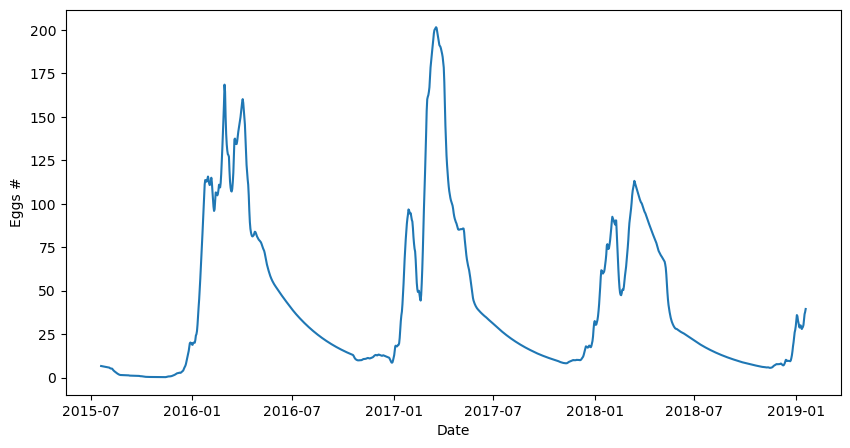

In [12]:
fig, axs = plt.subplots(1,figsize=(10,5))

axs.plot(df.index,df.E,label='Python')
axs.set_ylabel('Eggs #')
axs.set_xlabel('Date')

Text(0.5, 0, 'Date')

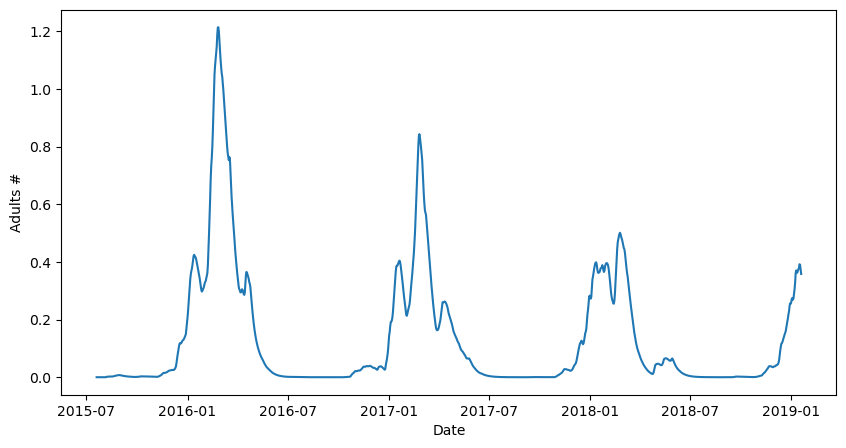

In [13]:
fig, axs = plt.subplots(1,figsize=(10,5))

axs.plot(df.index,df.A,label='Python')
axs.set_ylabel('Adults #')
axs.set_xlabel('Date')

Text(0.5, 0, 'Date')

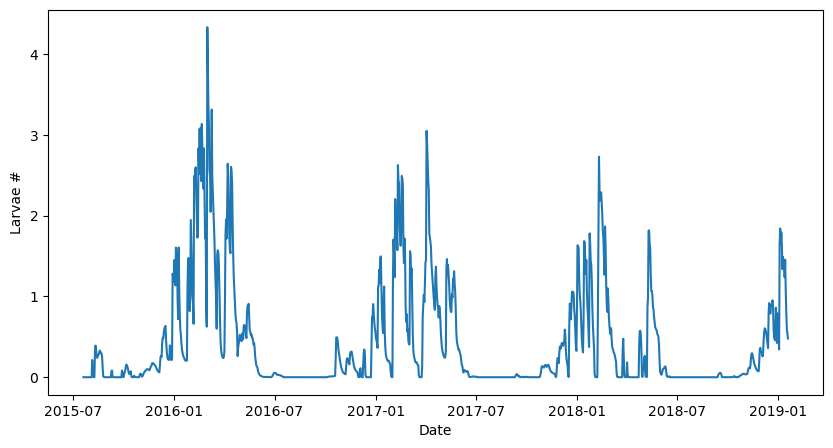

In [14]:
fig, axs = plt.subplots(1,figsize=(10,5))

axs.plot(df.index,df.L,label='Python')
axs.set_ylabel('Larvae #')
axs.set_xlabel('Date')